# Twitter Sentiment Analysis Project
This notebook demonstrates the process of sentiment analysis on Twitter data using Random Forest Classifier and SMOTE for handling imbalanced classes.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import string


In [2]:
# Preprocess the text data
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w.lower() not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    tokens = [w for w in tokens if w not in string.punctuation]
    return ' '.join(tokens)

In [3]:
# Load the dataset
# Display the first few rows of the dataset
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567900433542488064,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,569989168903819264,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
2,568089179520954368,positive,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada)
3,568928195581513728,negative,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada)
4,568594180014014464,negative,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...
10975,569934458364813313,neutral,American,NaN,Cottopanama85,NaN,0,@AmericanAir followback,NaN,2015-02-23 10:58:58 -0800,"ohio,panama",NaN
10976,568564006329434113,positive,United,NaN,PaulBEsteves,NaN,0,@united thanks for the help. Wish the phone re...,NaN,2015-02-19 16:13:17 -0800,Brooklyn,Eastern Time (US & Canada)
10977,569643648910028801,negative,US Airways,NaN,runfixsteve,NaN,0,@usairways the. Worst. Ever. #dca #customerser...,NaN,2015-02-22 15:43:24 -0800,"St. Augustine, Florida",NaN
10978,568864981917110272,negative,US Airways,NaN,CLChicosky,NaN,0,@nrhodes85: look! Another apology. DO NOT FLY ...,NaN,2015-02-20 12:09:15 -0800,NaN,NaN


In [4]:
print('df_train.shape: ', df_train.shape)

df_train.shape:  (10980, 12)


In [5]:
duplicated_tweet_df = df_train[df_train.duplicated(keep=False)]
duplicated_tweet_df.sort_values(by=['tweet_id'], inplace=True)
duplicated_tweet_df
df_train.drop_duplicates(keep='first', inplace=True)
print('df_train.shape: ', df_train.shape)

df_train.shape:  (10911, 12)


/var/folders/cw/xr79sggd2fn45f_fc779kt9w0000gn/T/ipykernel_44454/614415600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicated_tweet_df.sort_values(by=['tweet_id'], inplace=True)


In [6]:
new_df = df_train[['tweet_id', 'airline_sentiment', 'negativereason_gold', 'text', 'tweet_location']]
new_df.head(10)

,tweet_id,airline_sentiment,negativereason_gold,text,tweet_location
0,567900433542488064,negative,NaN,"@SouthwestAir I am scheduled for the morning, ...",Washington D.C.
1,569989168903819264,positive,NaN,@SouthwestAir seeing your workers time in and ...,"Indianapolis, Indiana; USA"
2,568089179520954368,positive,NaN,@united Flew ORD to Miami and back and had gr...,Illinois
3,568928195581513728,negative,NaN,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN
4,568594180014014464,negative,NaN,@united so our flight into ORD was delayed bec...,NaN
5,569677636613439488,negative,NaN,@united Why did you load us in this flying sar...,"Los Angeles, CA"
6,569658903044218880,negative,NaN,@JetBlue that is a stock response. Delays not ...,Gotham
7,568542766860541952,positive,NaN,@JetBlue That'd be nice! Hoping to rack up eno...,"Burlington, MA"
8,570116209263427584,negative,NaN,@united frankly worse customer service ever. P...,NaN
9,568870144891600896,positive,NaN,@SouthwestAir yeah haha. Never been in one. It...,NaN


In [7]:
new_df.shape

(10911, 5)

In [8]:
duplicates_in_newdf = new_df[new_df.duplicated(keep=False)]
duplicates_in_newdf.sort_values(['tweet_id'], inplace=True)
duplicates_in_newdf.shape

/var/folders/cw/xr79sggd2fn45f_fc779kt9w0000gn/T/ipykernel_44454/1605423660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates_in_newdf.sort_values(['tweet_id'], inplace=True)


(2, 5)

In [9]:
new_df.drop_duplicates(keep='first', inplace=True)
new_df.shape


/var/folders/cw/xr79sggd2fn45f_fc779kt9w0000gn/T/ipykernel_44454/3512436408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop_duplicates(keep='first', inplace=True)


(10910, 5)

In [10]:
new_df.isnull().sum()

tweet_id                   0
airline_sentiment          0
negativereason_gold    10886
text                       0
tweet_location          3531
dtype: int64

In [11]:
# Preprocess the text data

new_df['text'].apply(preprocess_text)

0        SouthwestAir scheduled morning 2 day fact yes ...
1        SouthwestAir seeing worker time time going bey...
2        united Flew ORD Miami back great crew service ...
3                 SouthwestAir dultch97 's horse radish 😤🐴
4        united flight ORD delayed Air Force One last f...
                               ...                        
10975                               AmericanAir followback
10976    united thanks help Wish phone rep could accomi...
10977             usairways Worst Ever dca customerservice
10978         nrhodes85 look Another apology FLY USAirways
10979    united far worst airline 4 plane delay 1 round...
Name: text, Length: 10910, dtype: object

In [12]:
df_train_model = new_df[(new_df['negativereason_gold'].notnull()) & (new_df['airline_sentiment'] == 'negative')]
df_test_model = new_df[(new_df['negativereason_gold'].isnull()) & (new_df['airline_sentiment'] == 'negative')]

X = df_train_model['text']
y = df_train_model['negativereason_gold']

vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [13]:
# Import necessary libraries
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_vectorized, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [14]:
# Import necessary libraries
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])


In [15]:
# Initialize and perform GridSearchCV for hyperparameter tuning
# param_grid = {
#     'clf__n_estimators': [100, 200, 300],
#     'clf__max_depth': [10, 20],
#     'clf__min_samples_split': [2, 5, 10],
#     'clf__min_samples_leaf': [1, 2, 4]
# }

# Upon testing, got the optimal parameters as below
param_grid = {'clf__max_depth': [10], 'clf__min_samples_leaf': [1], 'clf__min_samples_split': [2], 'clf__n_estimators': [100]}

grid_search = GridSearchCV(param_grid = param_grid, estimator=pipeline, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.1s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.1s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.1s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.1s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [10], 'clf__min_samples_leaf': [1],
                         'clf__min_samples_split': [2],
                         'clf__n_estimators': [100]},
             verbose=2)

In [16]:
print("Best paramaters:", grid_search.best_params_)

Best paramaters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [17]:
print("Model accuracy:", grid_search.score(X_test,y_test))

Model accuracy: 0.9


In [18]:
# Preprocess the text data
print(df_test_model.loc[:, 'text'][:3])
df_test_model.loc[:, 'text'] = df_test_model['text'].apply(preprocess_text)
print(df_test_model.loc[:, 'text'][:3])
df_test_vectorized = vectorizer.transform(df_test_model['text'])

0    @SouthwestAir I am scheduled for the morning, ...
3       @SouthwestAir @dultch97 that's horse radish 😤🐴
4    @united so our flight into ORD was delayed bec...
Name: text, dtype: object
0    SouthwestAir scheduled morning 2 day fact yes ...
3             SouthwestAir dultch97 's horse radish 😤🐴
4    united flight ORD delayed Air Force One last f...
Name: text, dtype: object


In [19]:
df_test_model.loc[:, 'negativereason_gold'] = grid_search.predict(df_test_vectorized)
new_df.update(df_test_model)
print(new_df.isnull().sum())

tweet_id                  0
airline_sentiment         0
negativereason_gold    4101
text                      0
tweet_location         3531
dtype: int64


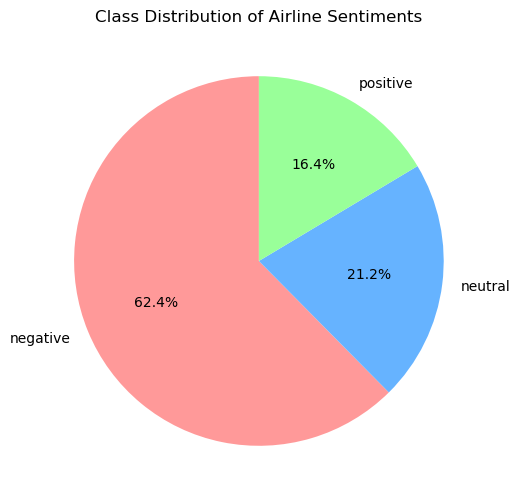

Splits: airline_sentiment
negative    6809
neutral     2310
positive    1791
Name: count, dtype: int64
shape: (10910, 5)


In [20]:
# Visualize class distribution as a pie chart
class_distribution = new_df['airline_sentiment'].value_counts()
plt.figure(figsize=(8, 6))
class_distribution.plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], startangle=90)
plt.title('Class Distribution of Airline Sentiments')
plt.ylabel('')
plt.show()

print("Splits:", new_df['airline_sentiment'].value_counts())
print("shape:",new_df.shape)


In [21]:
# Preprocess the text data
print(new_df['text'][:3])
new_df['text'] = new_df['text'].apply(preprocess_text)
print(new_df['text'][:3])
X_sentiment = new_df['text']
Y_sentiment = new_df['airline_sentiment']

0    SouthwestAir scheduled morning 2 day fact yes ...
1    @SouthwestAir seeing your workers time in and ...
2    @united Flew ORD to Miami and back and  had gr...
Name: text, dtype: object
0    SouthwestAir scheduled morning 2 day fact yes ...
1    SouthwestAir seeing worker time time going bey...
2    united Flew ORD Miami back great crew service ...
Name: text, dtype: object


/var/folders/cw/xr79sggd2fn45f_fc779kt9w0000gn/T/ipykernel_44454/774056335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['text'] = new_df['text'].apply(preprocess_text)


In [22]:
#Vectorize the text
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_vectorized_sentiment = vectorizer.fit_transform(X_sentiment)

In [23]:
# Split the data into training and testing sets
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X_vectorized_sentiment, Y_sentiment, test_size=0.3, random_state=42)

In [24]:
pipeline_sentiment = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

In [25]:
# param_grid_sentiment = {
#     'clf__n_estimators': [100, 200, 300],
#     'clf__max_depth': [None, 10, 20],
#     'clf__min_samples_split': [2, 5, 10],
#     'clf__min_samples_leaf': [1, 2, 4]
# }
# Again upon testing, got the optimal parameters as below
param_grid_sentiment = {'clf__max_depth': [None], 'clf__min_samples_leaf': [1], 'clf__min_samples_split': [2], 'clf__n_estimators': [100]}

In [26]:
# Initialize and perform GridSearchCV for hyperparameter tuning
grid_search_sentiment = GridSearchCV(param_grid=param_grid_sentiment, estimator=pipeline_sentiment, cv=5, n_jobs=-1, verbose=2)

In [27]:
grid_search_sentiment.fit(X_train_sentiment, y_train_sentiment)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  24.2s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  23.8s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  23.8s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  24.5s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  24.6s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None], 'clf__min_samples_leaf': [1],
                         'clf__min_samples_split': [2],
                         'clf__n_estimators': [100]},
             verbose=2)

In [28]:
print("Best parameters:", grid_search_sentiment.best_params_)
print("Model accuracy on training data:", grid_search_sentiment.score(X_test_sentiment, y_test_sentiment))

Best parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Model accuracy on training data: 0.7351054078826764


In [29]:
df_test.head(4)

,tweet_id,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569682010270101504,American,NaN,zsalim03,NaN,0,@AmericanAir In car gng to DFW. Pulled over 1h...,NaN,2015-02-22 18:15:50 -0800,Texas,Central Time (US & Canada)
1,569608307184242688,American,NaN,sa_craig,NaN,0,"@AmericanAir after all, the plane didn’t land ...",NaN,2015-02-22 13:22:57 -0800,"College Station, TX",Central Time (US & Canada)
2,567879304593408001,Southwest,NaN,DanaChristos,NaN,1,@SouthwestAir can't believe how many paying cu...,NaN,2015-02-17 18:52:31 -0800,CT,Eastern Time (US & Canada)
3,569757651539660801,US Airways,NaN,rossj987,NaN,0,@USAirways I can legitimately say that I would...,NaN,2015-02-22 23:16:24 -0800,"Washington, D.C.",Eastern Time (US & Canada)


In [30]:
# Preprocess the text data
df_test['text'] = df_test['text'].apply(preprocess_text)
df_test_vectorized = vectorizer.transform(df_test['text'])

In [31]:
y_test_pred = grid_search_sentiment.predict(df_test_vectorized)